# Consumer Price Index analysis

By Ben Welsh

A rudimentary analysis of the Consumer Price Index published by the U.S. Bureau of Labor Statistics. It was developed to verify the accuracy of the [cpi](https://github.com/datadesk/cpi) open-source Python wrapper that eases access to the official government data. 

### Import Python tools

In [1]:
import os
import json
import warnings
import pandas as pd
import altair as alt
from datetime import date, datetime, timedelta

In [2]:
warnings.simplefilter("ignore")

### Import the development version of this library

In [3]:
import os
import sys
this_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, this_dir)
import cpi

## Top-level numbers for the latest month

Query the seasonally-adjusted CPI-U, which is the variation used by the BLS in its release.

In [35]:
adjusted_cpiu = cpi.series.get(seasonally_adjusted=True).to_dataframe()

Filter down to monthly values

In [36]:
adjusted_cpiu = adjusted_cpiu[adjusted_cpiu.period_type == 'monthly']

Calculate the monthly percentage change

In [37]:
adjusted_cpiu['pct_change'] = (adjusted_cpiu.value.pct_change()*100)

Round it in the same manner as the BLS.

In [38]:
adjusted_cpiu['pct_change_rounded'] = adjusted_cpiu['pct_change'].round(1)

Cut down to the last 13 months

In [41]:
last_13 = adjusted_cpiu.sort_values("date").tail(13)

In [45]:
last_13[[
    'date',
    'value',
    'pct_change_rounded'
]]

,date,value,pct_change_rounded
250,2017-11-01,247.411,0.3
251,2017-12-01,247.910,0.2
252,2018-01-01,249.245,0.5
253,2018-02-01,249.619,0.2
254,2018-03-01,249.462,-0.1
255,2018-04-01,250.013,0.2
256,2018-05-01,250.535,0.2
257,2018-06-01,250.857,0.1
258,2018-07-01,251.286,0.2
259,2018-08-01,251.846,0.2


Get the latest month and change

In [46]:
latest_month, latest_change = last_13.sort_values("date", ascending=False)[['date', 'pct_change_rounded']].to_records(index=False)[0]

In [47]:
latest_month, latest_change

('2018-11-01', 0.0)

In [48]:
with open("./latest.json", "w") as fp:
    fp.write(json.dumps(dict(
        latest_month=latest_month,
        latest_change=latest_change
    )))

In [49]:
last_13.to_csv("./cpi-mom.csv", index=False)

### Match category analysis published by the BLS

In an October 2018 [post](https://www.bls.gov/opub/ted/2018/consumer-prices-up-2-point-3-percent-over-year-ended-september-2018.htm) the BLS published the following chart showing the month to month percentage change in the Consumer Price Index for All Urban Consumers across a select group of categories. We will replicate it below.

![](https://i.imgur.com/54RcrID.png)

Query the data series charted by the BLS

In [4]:
all_items = cpi.series.get(seasonally_adjusted=False).to_dataframe()

In [5]:
energy = cpi.series.get(items="Energy", seasonally_adjusted=False).to_dataframe()

In [6]:
food = cpi.series.get(items="Food", seasonally_adjusted=False).to_dataframe()

Write a function to prepare each series for presentation

In [7]:
def prep_yoy(df):
    # Trim down to monthly values
    df = df[df.period_type == 'monthly']
    # Calculate percentage change year to year
    df['pct_change'] = df.value.pct_change(12)
    # Trim down to the last 13 months
    return df.sort_values("date")

In [8]:
all_items_prepped = prep_yoy(all_items)

In [9]:
energy_prepped = prep_yoy(energy)

In [10]:
food_prepped = prep_yoy(food)

In [11]:
three_cats = pd.concat([
    all_items_prepped.tail(12*10),
    energy_prepped.tail(12*10),
    food_prepped.tail(12*10)
])

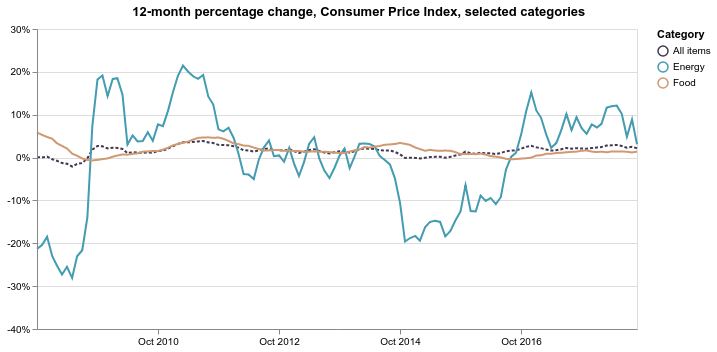

In [50]:
base = alt.Chart(
    three_cats,
    title="12-month percentage change, Consumer Price Index, selected categories"
).encode(
    x=alt.X(
        "date:T",
        timeUnit="yearmonth",
        axis=alt.Axis(
            title=None,
            labelAngle=0,
            grid=False,
            # A truly gnarly hack from https://github.com/altair-viz/altair/issues/187
            values=list(pd.to_datetime([
                '2008-11-01',
                '2010-11-01',
                '2012-11-01',
                '2014-11-01',
                '2016-11-01',
                '2018-11-01'
            ]).astype(int) / 10 ** 6)
        ),
    ),
    y=alt.Y(
        "pct_change:Q",
        axis=alt.Axis(title=None, format='%'),
        scale=alt.Scale(domain=[-0.4, 0.3])
    ),
    color=alt.Color(
        "series_items_name:N",
        legend=alt.Legend(title="Category"),
        scale=alt.Scale(range=["#423a51", "#449cb0", "#d09972"])
    )
)

all_items = base.transform_filter(
    alt.datum.series_items_name == 'All items'
).mark_line(strokeDash=[3, 2])

other_items = base.transform_filter(
    alt.datum.series_items_name != 'All items'
).mark_line()

(all_items + other_items).properties(width=600)

In [13]:
three_cats.to_csv("./three-categories-yoy.csv", index=False)

### A similar chart with a shorter timeframe

Here's another one.

![](https://i.imgur.com/h1nA41O.png)

In [14]:
all_less_energy_and_food = cpi.series.get(items="All items less food and energy", seasonally_adjusted=False).to_dataframe()

In [15]:
all_less_energy_and_food_prepped = prep_yoy(all_less_energy_and_food)

In [16]:
two_cats = pd.concat([
    all_items_prepped.tail(13),
    all_less_energy_and_food_prepped.tail(13),
])

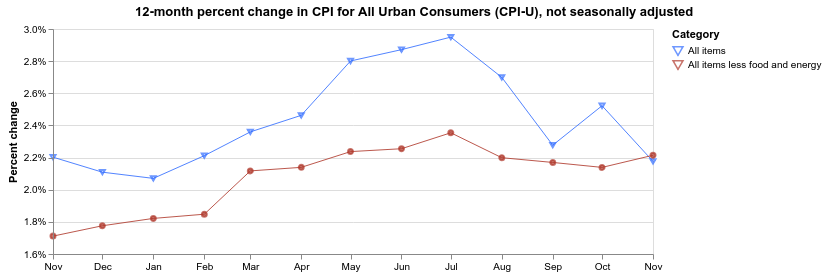

In [17]:
base = alt.Chart(
    two_cats,
    title="12-month percent change in CPI for All Urban Consumers (CPI-U), not seasonally adjusted"
).encode(
    x=alt.X(
        "date:T",
        timeUnit="utcyearmonth",
        axis=alt.Axis(
            title=None,
            labelAngle=0,
            grid=False,
            format="%b"
        )
    ),
    y=alt.Y(
        "pct_change:Q",
        axis=alt.Axis(title="Percent change", format='%'),
        scale=alt.Scale(domain=[0.016, 0.03])
    ),
    color=alt.Color(
        "series_items_name:N",
        legend=alt.Legend(title="Category"),
        scale=alt.Scale(range=["#336EFF", "#B03A2E",])
    )
)

line = base.mark_line(strokeWidth=0.85)
exes = base.transform_filter(alt.datum.series_items_name == 'All items').mark_point(shape="triangle-down", size=25)
points = base.transform_filter(alt.datum.series_items_name == 'All items less food and energy').mark_point(size=25, fill="#B03A2E")

(line + exes + points).properties(width=600, height=225)

In [18]:
two_cats.to_csv("./two-categories-yoy.csv", index=False)

### Match monthly analysis published by the BLS.

In a July 2018 [press release](https://www.bls.gov/news.release/pdf/cpi.pdf) the BLS published the following chart showing the month to month percentage change in the Consumer Price Index for All Urban Consumers, also known as the CPI-U. We will replicate it below.

![](https://i.imgur.com/zkLKG5B.png)

Draw the chart.

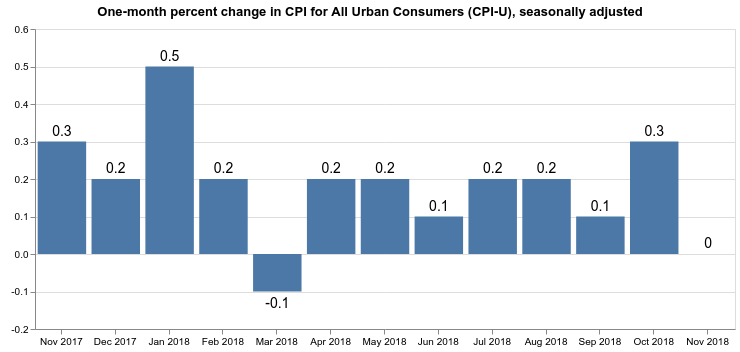

In [25]:
base = alt.Chart(
    last_13, 
    title="One-month percent change in CPI for All Urban Consumers (CPI-U), seasonally adjusted"
).properties(width=700)

bars = base.mark_bar().encode(
    x=alt.X(
        "date:O",
        timeUnit="utcyearmonth",
        axis=alt.Axis(title=None, labelAngle=0),
    ),
    y=alt.Y(
        "pct_change_rounded:Q",
        axis=alt.Axis(title=None),
        scale=alt.Scale(domain=[
            last_13['pct_change'].min()-0.1,
            last_13['pct_change'].max()+0.05
        ])
    )
)

text = base.encode(
    x=alt.X("date:O", timeUnit="utcyearmonth"),
    y="pct_change_rounded:Q",
    text='pct_change_rounded'
)

textAbove = text.transform_filter(alt.datum.pct_change > 0).mark_text(
    align='center',
    baseline='middle',
    fontSize=14,
    dy=-10
)

textBelow = text.transform_filter(alt.datum.pct_change < 0).mark_text(
    align='center',
    baseline='middle',
    fontSize=14,
    dy=12
)

bars + textAbove + textBelow